In [1]:
# Construct a TDSCatalog instance pointing to the gfs dataset
from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/catalog.xml')
print(list(best_gfs.datasets))

['Full Collection (Reference / Forecast Time) Dataset', 'Best GFS Half Degree Forecast Time Series', 'Latest Collection for GFS Half Degree Forecast']


In [2]:
# Pull out the dataset you want to use and look at the access URLs
best_ds = list(best_gfs.datasets.values())[1]
best_ds.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p5deg/Best',
 'ISO': 'http://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p5deg/Best',
 'NCML': 'http://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p5deg/Best',
 'NetcdfSubset': 'http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p5deg/Best',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg/Best',
 'UDDC': 'http://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p5deg/Best',
 'WCS': 'http://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p5deg/Best',
 'WMS': 'http://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p5deg/Best'}

In [3]:
# Create NCSS object to access the NetcdfSubset
from siphon.ncss import NCSS
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

In [5]:
from datetime import datetime
# Create lat/lon box for location you want to get data for
query = ncss.query()
query.lonlat_box(north=65, south=15, east=310, west=220).time(datetime.utcnow())
query.accept('netcdf4')

# Request data for vorticity
query.variables('Temperature_isobaric', 'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
query.vertical_level(85000)
data = ncss.get_data(query)

#Pull out variables you want to use
time_var = data.variables['time']
lat_var = data.variables['lat']
lon_var = data.variables['lon']
temp_var = data.variables['Temperature_isobaric']
u_wind_var = data.variables['u-component_of_wind_isobaric']
v_wind_var = data.variables['v-component_of_wind_isobaric']

In [6]:
import numpy as np
from netCDF4 import num2date
import scipy.ndimage as ndimage
from metpy.units import units

# Get actual data values and remove any size 1 dimensions
lat = lat_var[:].squeeze()
lon = lon_var[:].squeeze()
temp = temp_var[:].squeeze()
u_wind = u_wind_var[:].squeeze() * units('m/s')
v_wind = v_wind_var[:].squeeze() * units('m/s')

# Convert number of hours since the reference time into an actual date
time = num2date(time_var[:].squeeze(), time_var.units)

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)

In [7]:
from metpy.calc import advection

# Calculate temperature advection
adv = advection(temp * units.kelvin, [u_wind, v_wind], 
               (42583.44283066879 * units.meter, 55588.7366760194 * units.meter)) * units('degF/sec')
adv = ndimage.gaussian_filter(adv, sigma=1.5, order=0)

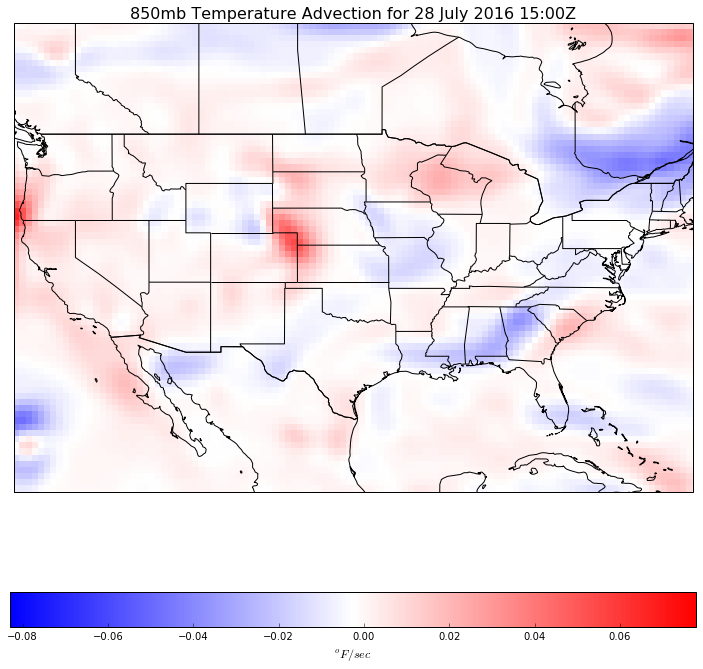

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create new figure
fig = plt.figure(figsize=(15,12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235., 290., 20., 55.])

# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)

# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                               scale='50m',facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)

#Contour the temperature advection and geopotential heights
c = ax.pcolor(lon_2d, lat_2d, adv, cmap='bwr')
cb = plt.colorbar(c, orientation='horizontal', shrink=.82)
cb.set_label(r'$^{o}F/sec$', size='large')

plt.title('850mb Temperature Advection for {0:%d %B %Y %H:%MZ}'.format(time), fontsize=16)
plt.show()